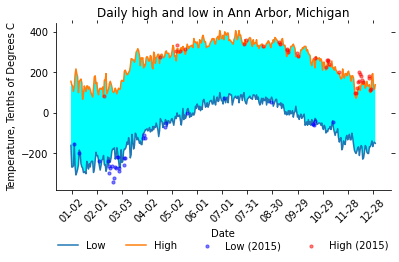

In [4]:
import matplotlib
import matplotlib.pyplot as plt
#import mplleaflet
import pandas as pd
import numpy as np
from nbconvert.exporters import notebook


def leaflet_plot_stations(binsize, hashid):
    df = pd.read_csv(r'BinSize.csv'.format(binsize))

    station_locations_by_hash = df[df['hash'] == hashid]

    lons = station_locations_by_hash['LONGITUDE'].tolist()
    lats = station_locations_by_hash['LATITUDE'].tolist()

    plt.figure(figsize=(8, 8))

    plt.scatter(lons, lats, c='r', alpha=0.7, s=200)

    return mplleaflet.display()


# leaflet_plot_stations(400, 'fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89')

df = pd.read_csv(r'temperature.csv')
df.head()
df.sort_values("Date").head()
# Add month-day column so we can find record breaking days from 2015
df["Month-Day"] = df.apply(lambda row: "-".join(row["Date"].split("-")[1:]), axis=1)

df[df["Month-Day"] == "01-01"].min()

dtype: object

df = df[df.Date.str.contains("-02-29") == False]

df.dtypes
df["Date"] = pd.to_datetime(df["Date"])

df.dtypes
tmax = df[df["Element"] == "TMAX"]
tmin = df[df["Element"] == "TMIN"]

tmin.sort_values("Date").head()
# Take year earlier than 2015
df_period_min = tmin[tmin["Date"] < "2015-01-01"]
df_period_max = tmax[tmax["Date"] < "2015-01-01"]

# Separate 2015
df_2015_min = tmin[tmin["Date"] >= "2015-01-01"]
df_2015_max = tmax[tmax["Date"] >= "2015-01-01"]

tmax_grouped = df_period_max.groupby("Month-Day").max()
tmin_grouped = df_period_min.groupby("Month-Day").min()

tmax_15_grouped = df_2015_max.groupby("Month-Day").max()
tmin_15_grouped = df_2015_min.groupby("Month-Day").min()

tmin_15_grouped = tmin_15_grouped.reset_index()
df_min = tmin_grouped.reset_index().merge(tmin_15_grouped, on="Month-Day").set_index("Month-Day")

tmax_15_grouped = tmax_15_grouped.reset_index()
df_max = tmax_grouped.reset_index().merge(tmax_15_grouped, on="Month-Day").set_index("Month-Day")

df_max.rename(columns={"Data_Value_y": "Data_Max_2015", "Data_Value_x": "Data_Value"}, inplace=True)
df_min.rename(columns={"Data_Value_y": "Data_Min_2015", "Data_Value_x": "Data_Value"}, inplace=True)

df_max.head()
df_min.head()

df_min["Data_Min_2015"] = df_min.apply(
    lambda row: row["Data_Min_2015"] if (row["Data_Min_2015"] < row["Data_Value"]) else np.NaN, axis=1)
df_max["Data_Max_2015"] = df_max.apply(
    lambda row: row["Data_Max_2015"] if (row["Data_Max_2015"] > row["Data_Value"]) else np.NaN, axis=1)

df_min = df_min.sort_index()
df_max = df_max.sort_index()
# %matplotlib notebook
# Reset indexes so plots can be drawn
df_min = df_min.reset_index()
df_max = df_max.reset_index()
import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

days = mdates.DayLocator()  # every day
years = mdates.YearLocator()  # every year
months = mdates.MonthLocator()  # every month
fmt = mdates.DateFormatter('%m-%d')

fig, ax = plt.subplots()
ax.plot(df_min.index, df_min["Data_Value"], label="Low")
ax.plot(df_max.index, df_max["Data_Value"], label="High")

# format the ticks
# ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(fmt)
# ax.xaxis.set_minor_locator(months)

ax.scatter(df_min.index, df_min["Data_Min_2015"], s=10, c="blue", alpha=0.5, label="Low (2015)", zorder=10)
ax.scatter(df_max.index, df_max["Data_Max_2015"], s=10, c="red", alpha=0.5, label="High (2015)", zorder=10)

ax.fill_between(df_min.index, df_min["Data_Value"], df_max["Data_Value"], facecolor='cyan')

# Simplify graph
plt.legend(loc=9, bbox_to_anchor=(0.5, -0.25), ncol=4, frameon=False)
ax.tick_params(top='off', bottom='on', left='off', right='off', labelleft='on', labelbottom='on')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# set labels and title
plt.xlabel("Date")
plt.ylabel("Temperature, Tenths of Degrees C")
plt.title("Daily high and low in Ann Arbor, Michigan")

ax.grid(False)
plt.xticks(np.arange(1, 365, 30), rotation=45)

# make some room for the legend
fig.subplots_adjust(bottom=0.3)

plt.show()
